# Pet Image Segmentation with Fully Convolutional Networks

This project implements semantic segmentation for pet images using the Oxford-IIIT Pet Dataset. The goal is to accurately separate pets from their backgrounds using deep learning techniques.

## Project Overview

This project demonstrates advanced computer vision techniques for **semantic segmentation**, specifically focusing on:

### **Dataset**: Oxford-IIIT Pet Dataset
- **37 pet categories** (12 cat breeds + 25 dog breeds)
- **Pixel-level annotations** for foreground/background segmentation
- **7,349 images** with corresponding segmentation masks
- **Trimap annotations** for precise boundary definition

### **Architecture**: Fully Convolutional Networks (FCN)
- **Backbone**: ResNet-50 pretrained on ImageNet
- **Decoder**: Upsampling layers for pixel-wise prediction
- **Output**: Binary segmentation (pet vs background)

### **Training Strategies Compared**:
1. **Training from Scratch**: Network trained without pretrained weights
2. **Transfer Learning**: Using pretrained ImageNet features
3. **Data Augmentation**: With and without horizontal flipping

### **Key Features**:
- **IoU Evaluation**: Intersection over Union metrics for segmentation quality
- **Comparative Analysis**: Different training approaches and their effectiveness
- **Visualization Tools**: Side-by-side image and mask display, overlay visualization
- **Model Persistence**: Save and load trained models

### **Technical Implementation**:
- **Framework**: PyTorch with segmentation-models-pytorch
- **Metrics**: Binary Jaccard Index (IoU) for evaluation
- **Data Augmentation**: Albumentations library
- **GPU Acceleration**: CUDA support for faster training

---

## Implementation Details

In [ ]:
%pip install segmentation-models-pytorch

In [ ]:
import os
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

# Dataset setup for Oxford-IIIT Pet Dataset
data_root = "oxford-iiit-pet"

# Download the dataset if it doesn't exist
SimpleOxfordPetDataset.download(root=data_root)

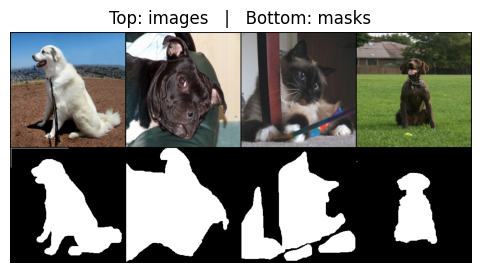

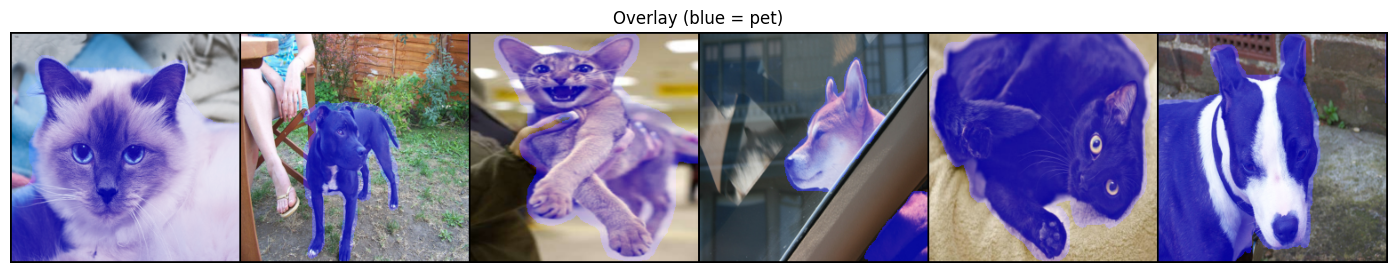

In [ ]:
import os, torch, matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import albumentations as A
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset
from torchvision.utils import make_grid

# Pet Segmentation Dataset Setup
DATA_ROOT = "oxford-iiit-pet"
SimpleOxfordPetDataset.download(DATA_ROOT)

# Data transformations and datasets
train_tf_no_aug = A.Compose([])                         # no augmentation
train_tf_hflip  = A.Compose([A.HorizontalFlip(p=0.5)])  # horizontal flip
val_test_tf     = A.Compose([])

train_ds_basic = SimpleOxfordPetDataset(DATA_ROOT, "train", transform=train_tf_no_aug)
train_ds_flip  = SimpleOxfordPetDataset(DATA_ROOT, "train", transform=train_tf_hflip)
val_ds         = SimpleOxfordPetDataset(DATA_ROOT, "valid", transform=val_test_tf)
test_ds        = SimpleOxfordPetDataset(DATA_ROOT, "test",  transform=val_test_tf)

# Create data loaders
BATCH = 8
train_loader_basic = DataLoader(train_ds_basic, batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=True)
train_loader_flip  = DataLoader(train_ds_flip,  batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=True)
val_loader         = DataLoader(val_ds,        batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
test_loader        = DataLoader(test_ds,       batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Visualization functions
def show_batch(loader, mode="side", n=4):
    if isinstance(loader, torch.utils.data.Dataset):
        loader = DataLoader(loader, batch_size=n, shuffle=False, num_workers=0)

    batch = next(iter(loader))
    imgs  = batch["image"][:n].float() / 255.0      # uint8 → float32 ∈[0,1]
    masks = batch["mask"][:n]
    if masks.dim() == 3:
        masks = masks.unsqueeze(1)
    masks = masks.float()

    if mode == "side":
        vis = torch.cat([imgs, masks.repeat(1,3,1,1)], 0)
        title = "Top: images   |   Bottom: masks"
    elif mode == "overlay":
        overlay = imgs.clone()
        overlay[:,2] = torch.where(masks[:,0]>0, 1.0, overlay[:,2])  # blue
        vis, title = overlay*0.6 + imgs*0.4, "Overlay (blue = pet)"
    else:
        raise ValueError("mode must be 'side' or 'overlay'")

    grid = make_grid(vis, nrow=n, padding=2).permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(3*n, 3)); plt.imshow(grid); plt.axis("off"); plt.title(title); plt.show()

show_batch(train_loader_basic, mode="side",    n=4)
show_batch(train_loader_flip,  mode="overlay", n=6)

# Display sample images and masks


===== Experiment: pretrain_no_aug =====
Epoch  1/10 | Train L 0.264 IoU 0.765 | Val L 0.211 IoU 0.806
Epoch  2/10 | Train L 0.204 IoU 0.817 | Val L 0.217 IoU 0.807
Epoch  3/10 | Train L 0.184 IoU 0.834 | Val L 0.185 IoU 0.815
Epoch  4/10 | Train L 0.159 IoU 0.853 | Val L 0.239 IoU 0.792
Epoch  5/10 | Train L 0.154 IoU 0.858 | Val L 0.398 IoU 0.745
Epoch  6/10 | Train L 0.140 IoU 0.870 | Val L 0.180 IoU 0.843
Epoch  7/10 | Train L 0.113 IoU 0.893 | Val L 0.161 IoU 0.856
Epoch  8/10 | Train L 0.135 IoU 0.873 | Val L 0.213 IoU 0.824
Epoch  9/10 | Train L 0.129 IoU 0.879 | Val L 0.192 IoU 0.824
Epoch 10/10 | Train L 0.114 IoU 0.892 | Val L 0.172 IoU 0.853
→ Test IoU: 0.858

===== Experiment: pretrain_flip =====
Epoch  1/10 | Train L 0.261 IoU 0.769 | Val L 0.239 IoU 0.771
Epoch  2/10 | Train L 0.213 IoU 0.809 | Val L 0.203 IoU 0.817
Epoch  3/10 | Train L 0.191 IoU 0.828 | Val L 0.180 IoU 0.833
Epoch  4/10 | Train L 0.179 IoU 0.838 | Val L 0.182 IoU 0.831
Epoch  5/10 | Train L 0.167 IoU 0.

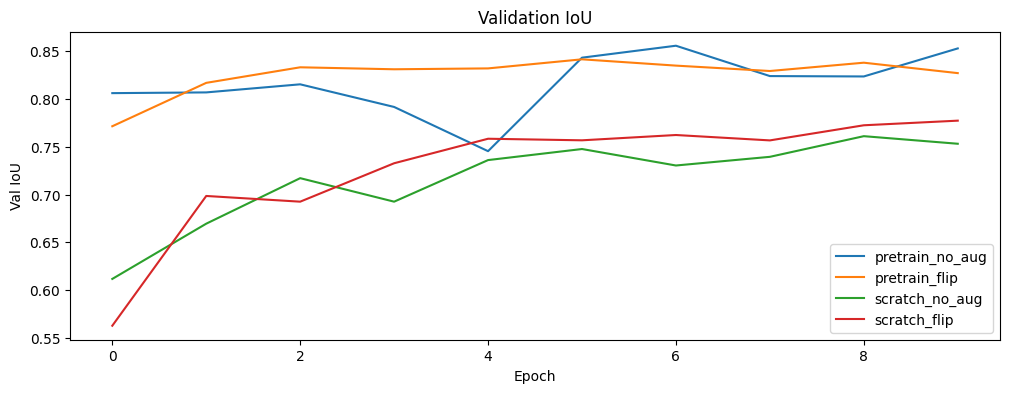


=== Test-set IoU ===
pretrain_no_aug: 0.858
pretrain_flip  : 0.832
scratch_no_aug : 0.761
scratch_flip   : 0.786


In [8]:
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import models
from torchmetrics.classification import BinaryJaccardIndex  # ← 方法 A
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE  = 256
LR        = 1e-3
EPOCHS    = 10
NUM_CLASS = 1

# ===========================================================================
# (b) Build the model, by constructing a FCN with ResNet-18 backbone
# ===========================================================================
class FCNResNet18(nn.Module):
    def __init__(self, pretrained: bool = True):
        super().__init__()
        resnet = models.resnet18(
            weights="IMAGENET1K_V1" if pretrained else None
        )
        self.backbone = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
        )
        self.head     = nn.Conv2d(512, NUM_CLASS, 1)
        self.up       = nn.Upsample(scale_factor=32, mode="bilinear",
                                    align_corners=False)

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        x = self.up(x)
        return x                        # (B,1,H,W)

# ===========================================================================
# (c) Train the model
# ===========================================================================
criterion = nn.BCEWithLogitsLoss()

# define metrics
def metrics_batch(logits, masks):
    preds = (torch.sigmoid(logits) > 0.5).long()
    acc   = (preds == masks).float().mean()

    iou_metric = BinaryJaccardIndex().to(logits.device)
    iou = iou_metric(preds, masks)

    return acc.item(), iou.item()


def run_epoch(model, loader, optimizer=None):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()

    sum_loss = sum_acc = sum_iou = 0
    n_batches = len(loader)

    with (torch.enable_grad() if train_mode else torch.no_grad()):
        for batch in loader:
            imgs  = batch["image"].to(DEVICE).float() / 255.0
            masks = batch["mask" ].to(DEVICE).long()
            if masks.dim() == 3:
                masks = masks.unsqueeze(1)

            logits = model(imgs)
            loss   = criterion(logits, masks.float())

            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            acc, iou = metrics_batch(logits, masks)
            sum_loss += loss.item()
            sum_acc  += acc
            sum_iou  += iou

    return (sum_loss / n_batches,
            sum_acc  / n_batches,
            sum_iou  / n_batches)

# Evaluate strategies: with/without augmentation, pretrained/scratch
experiments = {
    "pretrain_no_aug": dict(pretrained=True,  loader=train_loader_basic),
    "pretrain_flip" : dict(pretrained=True,  loader=train_loader_flip ),
    "scratch_no_aug": dict(pretrained=False, loader=train_loader_basic),
    "scratch_flip"  : dict(pretrained=False, loader=train_loader_flip ),
}

history = {}

for tag, cfg in experiments.items():
    print(f"\n===== Experiment: {tag} =====")
    model = FCNResNet18(pretrained=cfg["pretrained"]).to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=LR)

    record = {"train_loss":[], "val_loss":[], "train_iou":[], "val_iou":[]}

    for epoch in range(1, EPOCHS + 1):
        tr_loss, _,  tr_iou  = run_epoch(model, cfg["loader"], optim)
        va_loss, _,  va_iou  = run_epoch(model, val_loader)

        record["train_loss"].append(tr_loss)
        record["val_loss"  ].append(va_loss)
        record["train_iou" ].append(tr_iou)
        record["val_iou"   ].append(va_iou)

        print(f"Epoch {epoch:2}/{EPOCHS} | "
              f"Train L {tr_loss:.3f} IoU {tr_iou:.3f} | "
              f"Val L {va_loss:.3f} IoU {va_iou:.3f}")

    # evaluate on test set
    te_loss, _, te_iou = run_epoch(model, test_loader)
    record["test_iou"] = te_iou
    print(f"→ Test IoU: {te_iou:.3f}")

    history[tag] = record
    torch.save(model.state_dict(), f"fcn_{tag}.pth")

# Plot the training curves
plt.figure(figsize=(12,4))
for tag, rec in history.items():
    plt.plot(rec["val_iou"], label=tag)
plt.xlabel("Epoch"); plt.ylabel("Val IoU"); plt.title("Validation IoU"); plt.legend(); plt.show()

print("\n=== Test-set IoU ===")
for tag, rec in history.items():
    print(f"{tag:15s}: {rec['test_iou']:.3f}")


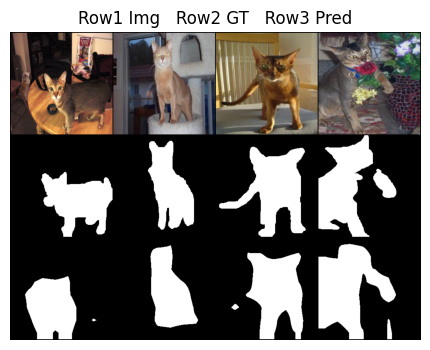

In [ ]:
# Model Evaluation and Visualization
def visualize(model, loader, count=3, mode="side"):
    model.eval()
    batch = next(iter(loader))

    imgs  = batch["image"][:count].to(DEVICE).float() / 255.0
    gts   = batch["mask" ][:count]
    if gts.dim() == 3:
        gts = gts.unsqueeze(1)

    with torch.no_grad():
        preds = (torch.sigmoid(model(imgs)) > 0.5).cpu().long()
    if preds.dim() == 3:
        preds = preds.unsqueeze(1)

    imgs = imgs.cpu()

    # overlay mode
    if mode == "overlay":
        stack = []
        for i in range(count):
            img = imgs[i].clone()
            gt  = gts[i, 0]        # (H,W)
            pd  = preds[i, 0]      # (H,W)

            img[2] = torch.where(gt>0, 1.0, img[2])   # GT → Blue channel
            img[0] = torch.where(pd>0, 1.0, img[0])   # Pred → Red channel
            stack.append(img)

        grid = make_grid(stack, nrow=count).permute(1,2,0).numpy()
        plt.figure(figsize=(4*count,4))
        plt.imshow(grid); plt.axis("off")
        plt.title("Overlay  Blue=GT  Red=Pred")
        plt.show()

    # side-by-side mode
    else:
        gts_rgb   = gts.repeat(1,3,1,1).float()       # (B,3,H,W)
        preds_rgb = preds.repeat(1,3,1,1).float()
        vis = torch.cat([imgs, gts_rgb, preds_rgb], 0)
        grid = make_grid(vis, nrow=count).permute(1,2,0).numpy()
        plt.figure(figsize=(4*count,4))
        plt.imshow(grid); plt.axis("off")
        plt.title("Row1 Img   Row2 GT   Row3 Pred")
        plt.show()


# visualize the best model
best_tag = max(history, key=lambda k: history[k]["test_iou"])
best_model = FCNResNet18(pretrained=False).to(DEVICE)
best_model.load_state_dict(torch.load(f"fcn_{best_tag}.pth", map_location=DEVICE))

visualize(best_model, test_loader, count=4, mode="side")